In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
from shapely.geometry import Point
from geopandas import GeoDataFrame
from cartopy.io import shapereader
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-white')

/var/folders/0g/51ngyll510j8j7tlj08dk5m00000gn/T/ipykernel_30943/253199284.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
ROOT = Path().resolve()
DATA = ROOT / 'data'

In [3]:
df = pd.read_csv(DATA / 'full_data_2013_2023.csv')
print(df.head())

   Unnamed: 0                      time  latitude  longitude  depth  mag  \
0           0  2013-01-31T23:57:01.070Z  -11.0000   165.4960   10.0  4.6   
1           1  2013-01-31T23:40:36.442Z   60.3617  -151.0058   69.6  2.7   
2           2  2013-01-31T23:27:50.960Z   55.7490  -160.8290   15.8  2.5   
3           3  2013-01-31T22:22:51.060Z   19.6250   -65.5160   52.0  3.2   
4           4  2013-01-31T22:03:06.754Z   55.3801  -135.0922   20.0  2.9   

  magType   nst    gap  dmin  ...                   updated  \
0      mb  33.0   90.8   NaN  ...  2014-11-07T01:49:55.379Z   
1      ml   NaN    NaN   NaN  ...  2019-05-13T22:59:09.085Z   
2      ml   9.0  176.8   NaN  ...  2019-05-13T22:59:08.321Z   
3      md   6.0  275.0   NaN  ...  2014-11-07T01:49:55.370Z   
4      ml   NaN    NaN   NaN  ...  2019-05-13T22:59:29.761Z   

                                  place        type horizontalError  \
0     44 km SW of Lata, Solomon Islands  earthquake             NaN   
1         14 km SSE of

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294570 entries, 0 to 294569
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       294570 non-null  int64  
 1   time             294570 non-null  object 
 2   latitude         294570 non-null  float64
 3   longitude        294570 non-null  float64
 4   depth            294570 non-null  float64
 5   mag              294570 non-null  float64
 6   magType          294569 non-null  object 
 7   nst              98227 non-null   float64
 8   gap              262660 non-null  float64
 9   dmin             238991 non-null  float64
 10  rms              292319 non-null  float64
 11  net              294570 non-null  object 
 12  id               294570 non-null  object 
 13  updated          294570 non-null  object 
 14  place            292752 non-null  object 
 15  type             294570 non-null  object 
 16  horizontalError  238776 non-null  floa

In [5]:
print(df.describe())

          Unnamed: 0       latitude      longitude          depth  \
count  294570.000000  294570.000000  294570.000000  294570.000000   
mean   147284.500000      18.606225     -37.203389      57.959296   
std     85035.178735      30.353417     123.704770     109.010954   
min         0.000000     -82.883700    -179.999700      -3.740000   
25%     73642.250000      -5.347600    -151.709175      10.000000   
50%    147284.500000      19.400000     -71.267900      15.400000   
75%    220926.750000      41.899475     107.730675      52.837500   
max    294569.000000      87.386000     179.999900     697.360000   

                 mag           nst            gap           dmin  \
count  294570.000000  98227.000000  262660.000000  238991.000000   
mean        3.767698     33.338909     128.451239       2.587237   
std         0.884589     39.531231      75.602535       4.323811   
min         2.120000      0.000000       7.000000       0.000000   
25%         2.870000     13.000000    

In [6]:
print(df.isnull().sum())

Unnamed: 0              0
time                    0
latitude                0
longitude               0
depth                   0
mag                     0
magType                 1
nst                196343
gap                 31910
dmin                55579
rms                  2251
net                     0
id                      0
updated                 0
place                1818
type                    0
horizontalError     55794
depthError           4809
magError            53228
magNst              48276
status                  0
locationSource          0
magSource               0
dtype: int64


In [7]:
# Since there is only one missing value for magType, we can fill it with the mode
df['magType'] = df['magType'].fillna(df['magType'].mode()[0])

In [8]:
df['time'] = pd.to_datetime(df['time'])
df['year'] = df['time'].dt.year

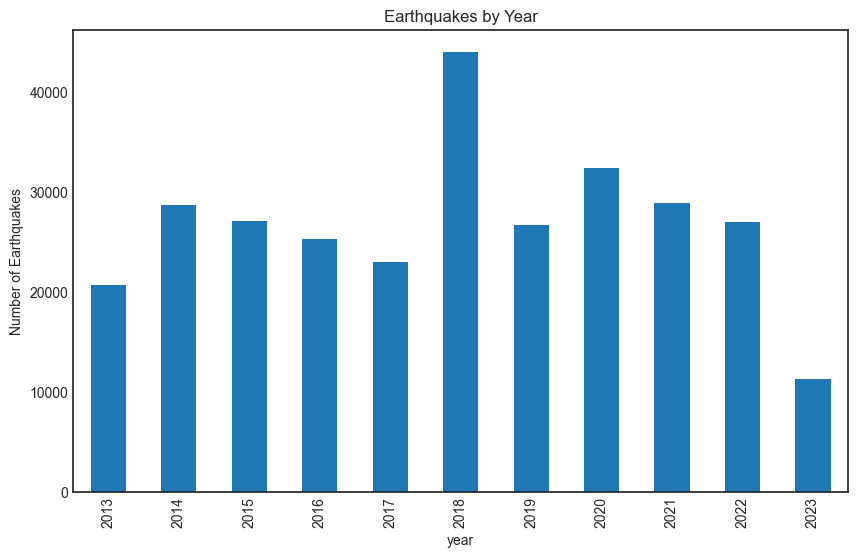

In [9]:
# Number of earthquakes by year
plt.figure(figsize=(10,6))
plt.title('Earthquakes by Year')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
df.groupby('year').count()['time'].plot(kind='bar')
plt.show()

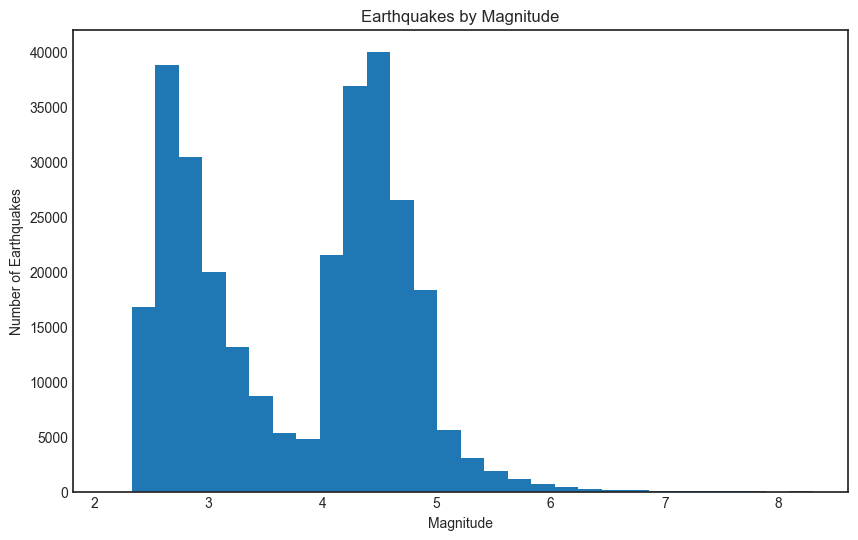

In [10]:
# Distribution of earthquakes by magnitude
plt.figure(figsize=(10,6))
plt.title('Earthquakes by Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Number of Earthquakes')
plt.hist(df["mag"], bins=30)
plt.show()

# The distribution is bimodal

In [11]:
# get location from place
df['location'] = df['place'].str.replace('.*,\\s*', '', regex=True)

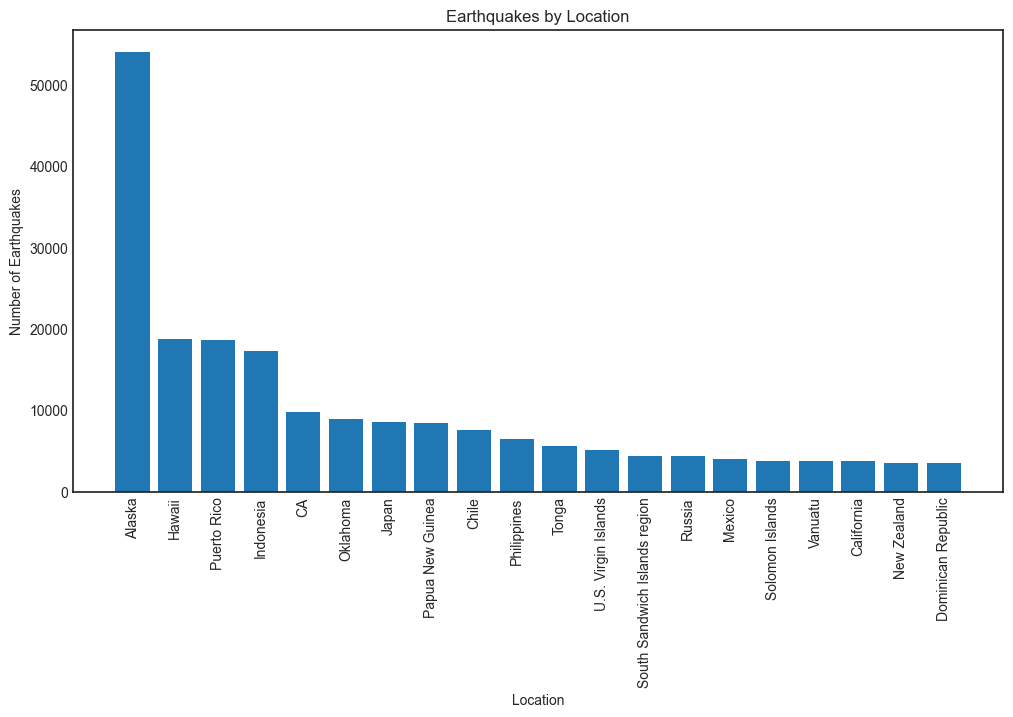

In [12]:
# Number of earthquakes by location
plt.figure(figsize=(12,6))
plt.title('Earthquakes by Location')
plt.xlabel('Location')
plt.ylabel('Number of Earthquakes')
plt.bar(df['location'].value_counts().head(20).index, df['location'].value_counts().head(20))
plt.xticks(rotation=90)
plt.show()

In [13]:
# filter top 5 locations with highest number of earthquakes
top_locations = df['location'].value_counts().head(5)

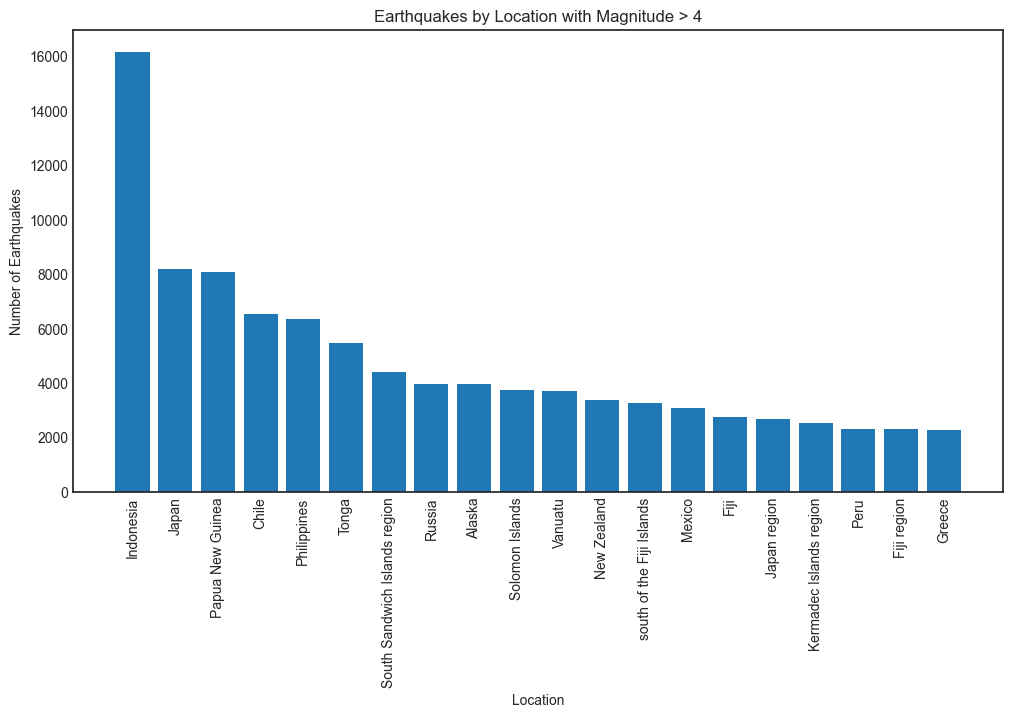

In [14]:
# filter locations with magnitude greater than 4
location_mag_4 = df[df['mag'] > 4]['location']

# plot
plt.figure(figsize=(12,6))
plt.title('Earthquakes by Location with Magnitude > 4')
plt.xlabel('Location')
plt.ylabel('Number of Earthquakes')
plt.bar(location_mag_4.value_counts().head(20).index, location_mag_4.value_counts().head(20))
plt.xticks(rotation=90)
plt.show()

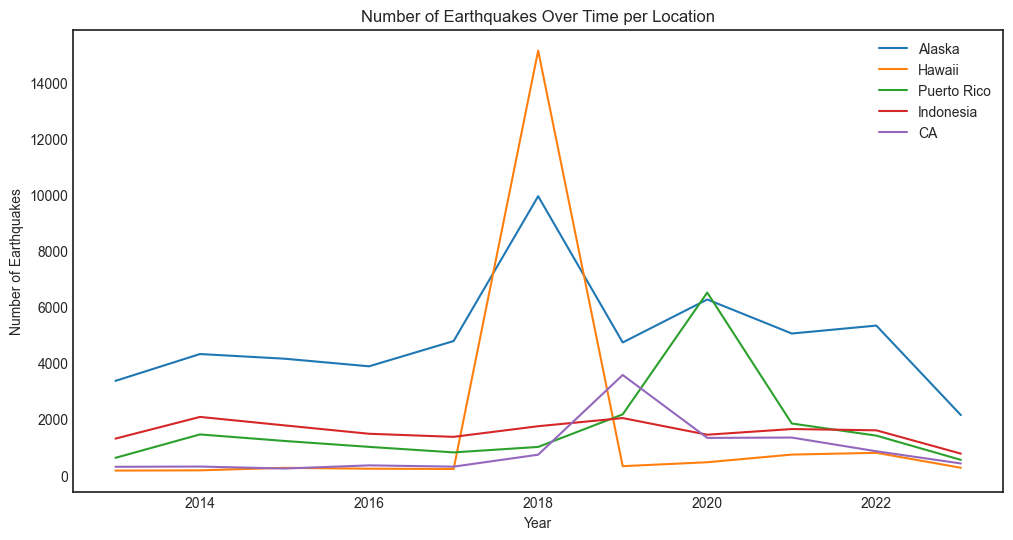

In [15]:
# check for local trend
fig, ax = plt.subplots(figsize=(12,6))

for location in top_locations.index:
    # Filter dataframe to only include rows with this location
    location_df = df[df['location'] == location]

    # Count the number of earthquakes in each year
    yearly_counts = location_df['year'].value_counts().sort_index()

    # Plot the yearly counts
    ax.plot(yearly_counts.index, yearly_counts.values, label=location)

# Add labels and title
plt.title('Number of Earthquakes Over Time per Location')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.legend()

plt.show()


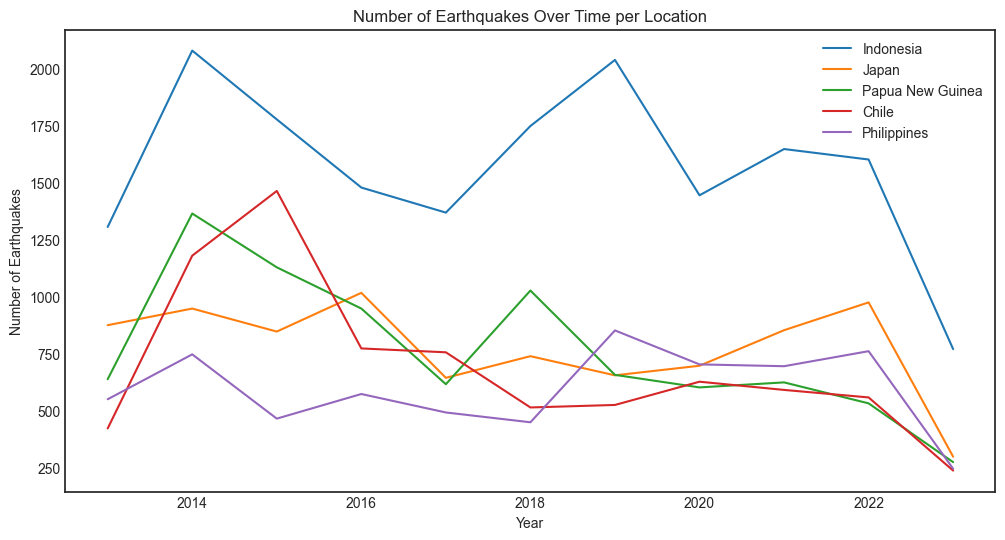

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

for location in location_mag_4.value_counts().head(5).index:
    # Filter dataframe to only include rows with this location
    location_df = df[df['location'] == location]

    # Count the number of earthquakes in each year
    yearly_counts = location_df['year'].value_counts().sort_index()

    # Plot the yearly counts
    ax.plot(yearly_counts.index, yearly_counts.values, label=location)

# Add labels and title
plt.title('Number of Earthquakes Over Time per Location')
plt.xlabel('Year')
plt.ylabel('Number of Earthquakes')
plt.legend()

plt.show()

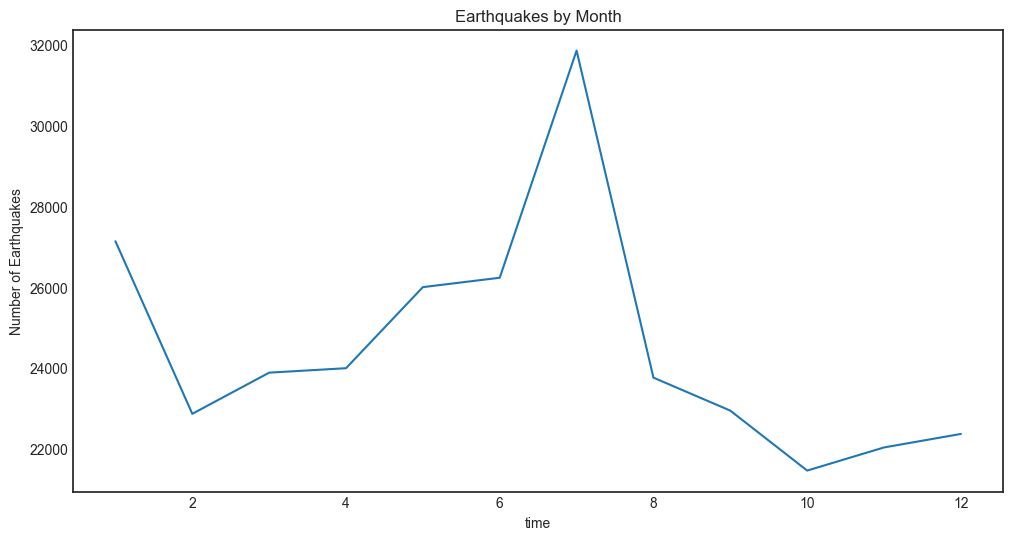

In [17]:
# plot a line graph of the number of earthquakes per month
plt.figure(figsize=(12,6))
plt.title('Earthquakes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Earthquakes')
df.groupby(df['time'].dt.month).count()['time'].plot(kind='line')
plt.show()

In [18]:
# Check this trend with a yearly frequency

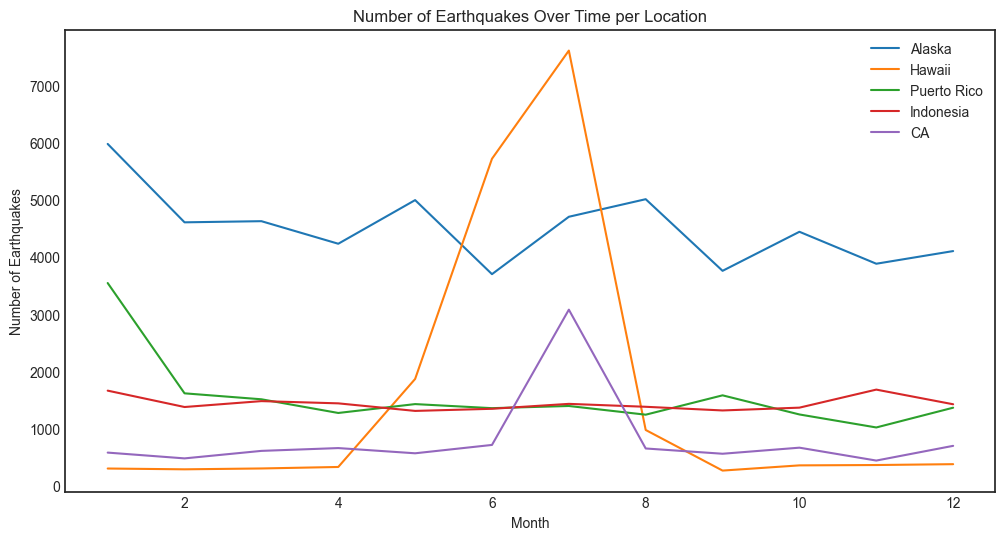

In [19]:
# plot a line graph for top 10 locations for magnitude with highest number of earthquakes per month
fig, ax = plt.subplots(figsize=(12,6))

for location in top_locations.index:
    # Filter dataframe to only include rows with this location
    location_df = df[df['location'] == location]

    # Count the number of earthquakes in each month
    monthly_counts = location_df['time'].dt.month.value_counts().sort_index()

    # Plot the monthly counts
    ax.plot(monthly_counts.index, monthly_counts.values, label=location)

# Add labels and title
plt.title('Number of Earthquakes Over Time per Location')
plt.xlabel('Month')
plt.ylabel('Number of Earthquakes')
plt.legend()


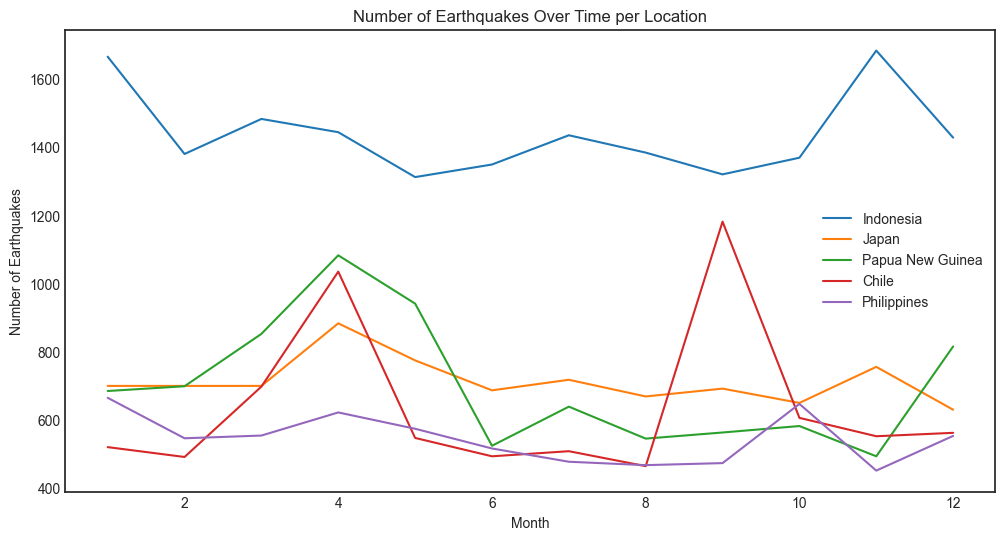

In [20]:
# plot a line graph for top 10 locations for magnitude greater than 4 with highest number of earthquakes per month
fig, ax = plt.subplots(figsize=(12,6))

for location in location_mag_4.value_counts().head(5).index:
    # Filter dataframe to only include rows with this location
    location_df = df[df['location'] == location]

    # Count the number of earthquakes in each month
    monthly_counts = location_df['time'].dt.month.value_counts().sort_index()

    # Plot the monthly counts
    ax.plot(monthly_counts.index, monthly_counts.values, label=location)

# Add labels and title
plt.title('Number of Earthquakes Over Time per Location')
plt.xlabel('Month')
plt.ylabel('Number of Earthquakes')
plt.legend()

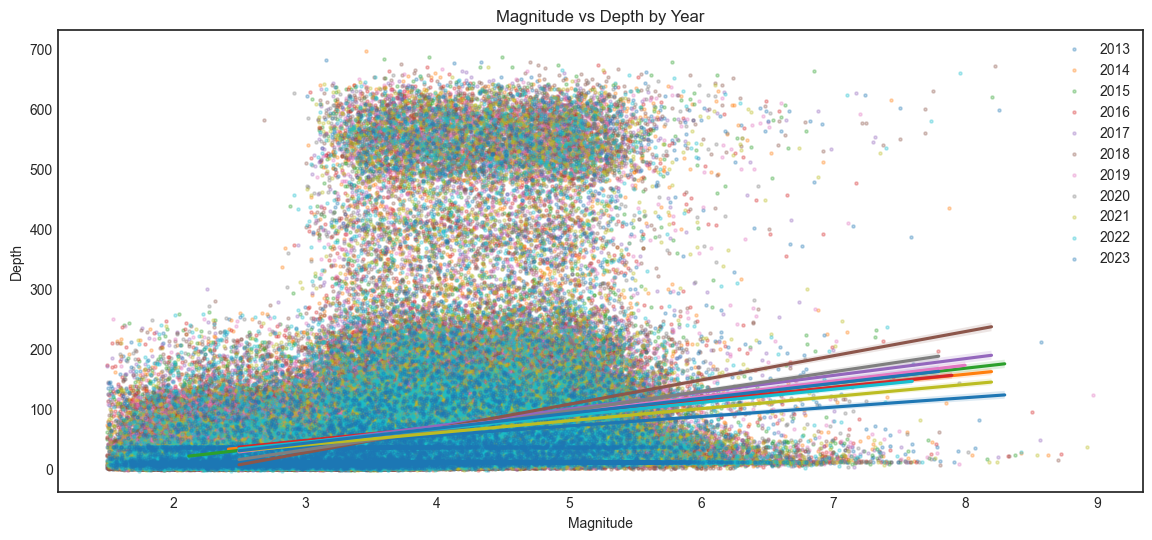

In [21]:
# plot magnitude vs depth by month
plt.figure(figsize=(14,6))
plt.title('Magnitude vs Depth by Year')

for year in df['time'].dt.year.unique():
    year_df = df[df['time'].dt.year == year]
    sns.regplot(x=year_df['mag'], y=year_df['depth'], label=year, x_jitter=True, scatter_kws={'alpha':0.3, 's':5})

# sns.relplot(data=df, x='year', y='depth', sizes='mag', **{'alpha':0.3, 's':5})

plt.xlabel('Magnitude')
plt.ylabel('Depth')
plt.legend()
plt.show()


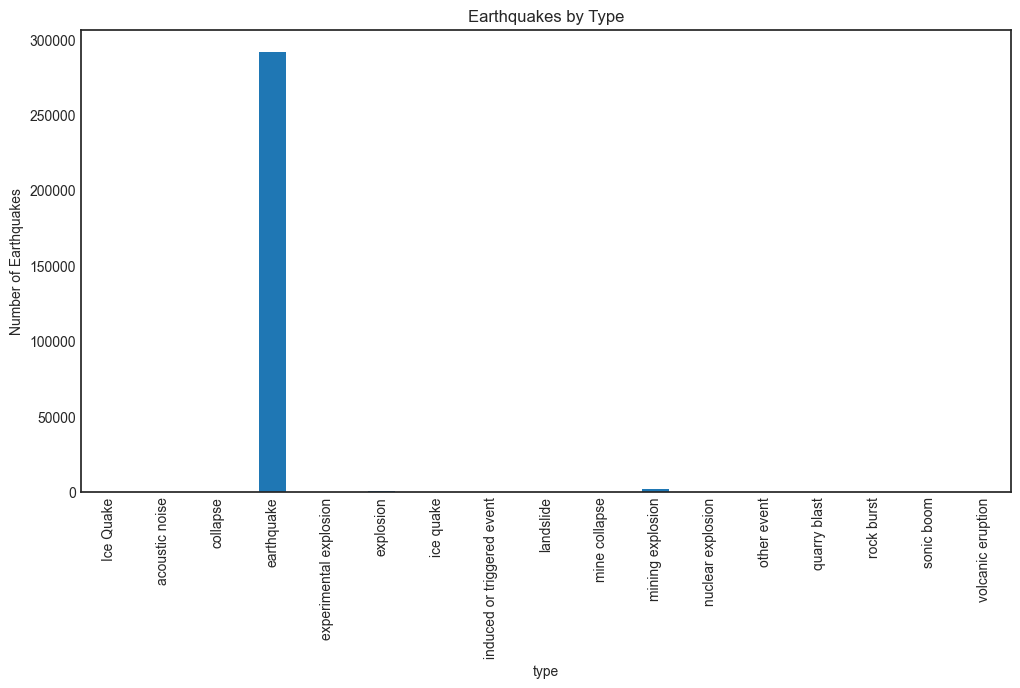

In [22]:
# plot type of earthquake
plt.figure(figsize=(12,6))
plt.title('Earthquakes by Type')
plt.xlabel('Type')
plt.ylabel('Number of Earthquakes')
df.groupby('type').count()['time'].plot(kind='bar')
plt.show()

In [23]:
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

/Users/parthshah/Desktop/repo/earthquake_analysis/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [24]:
cmap = plt.cm.get_cmap('viridis')

/var/folders/0g/51ngyll510j8j7tlj08dk5m00000gn/T/ipykernel_30943/1454545130.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


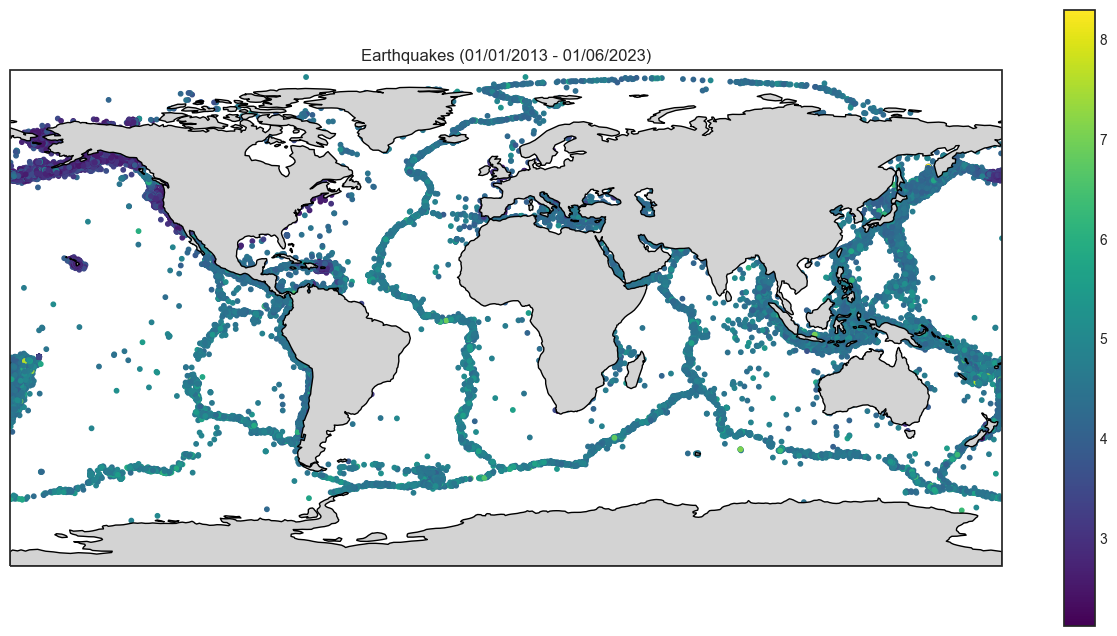

In [25]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
shapefile = shapereader.natural_earth(resolution='110m', category='physical', name='land')
ax.add_geometries(shapereader.Reader(shapefile).geometries(), ccrs.PlateCarree(), facecolor='lightgray', edgecolor='black')
gdf.plot(ax=ax, marker='o', markersize=10, column='mag', cmap=cmap, legend=True)
plt.title('Earthquakes (01/01/2013 - 01/06/2023)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

/var/folders/0g/51ngyll510j8j7tlj08dk5m00000gn/T/ipykernel_30943/1574856069.py:12: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


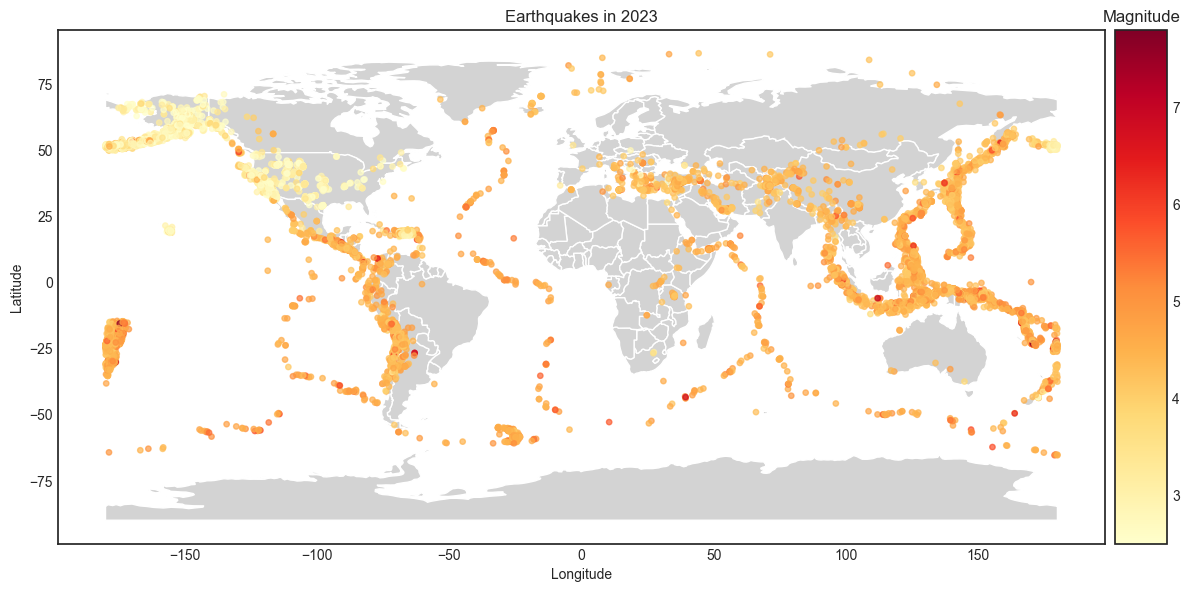

In [26]:
df = df[df['year'] == 2023]

geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Create the map figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Load a world map shapefile as the background
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot the earthquakes on the map with color and size based on magnitude
sc = gdf.plot(ax=ax, markersize=15, column='mag', cmap='YlOrRd', alpha=0.7, legend=True, cax=cax)

# Set plot title and labels
ax.set_title('Earthquakes in 2023')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust colorbar
cax.set_title('Magnitude')
cax.patch.set_alpha(1.0)  # Set colorbar background to be non-transparent

# Show the map
plt.tight_layout()
plt.show()

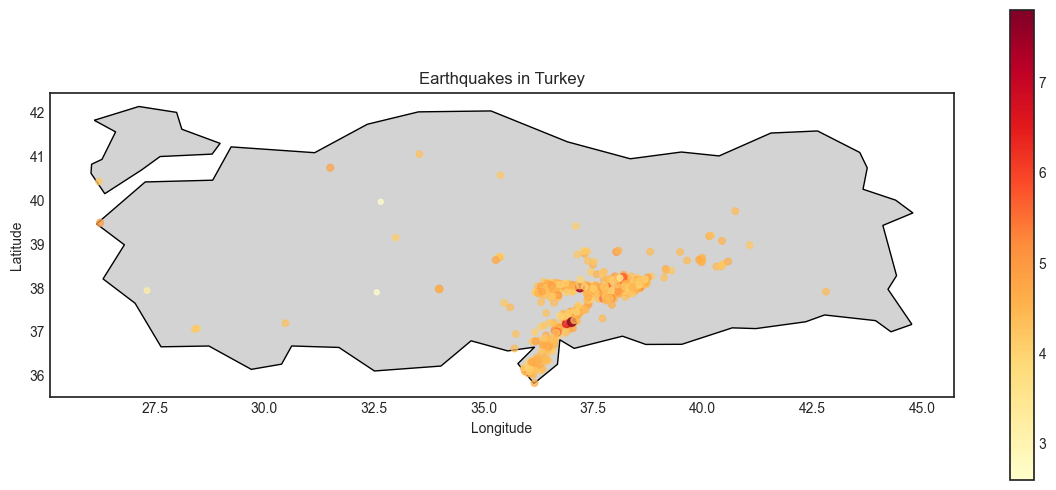

In [27]:
turkey = world[world['name'] == 'Turkey']

# Create a plot with a specific size and projection for Turkey
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_aspect('auto')
turkey.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the earthquakes within Turkey
gdf_turkey = gdf[gdf.within(turkey.geometry.iloc[0])]
gdf_turkey.plot(ax=ax, markersize=gdf_turkey['mag'] * 5, column='mag', cmap='YlOrRd', alpha=0.7, legend=True)

# Set plot title and labels
ax.set_title('Earthquakes in Turkey')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.tight_layout()
plt.show()

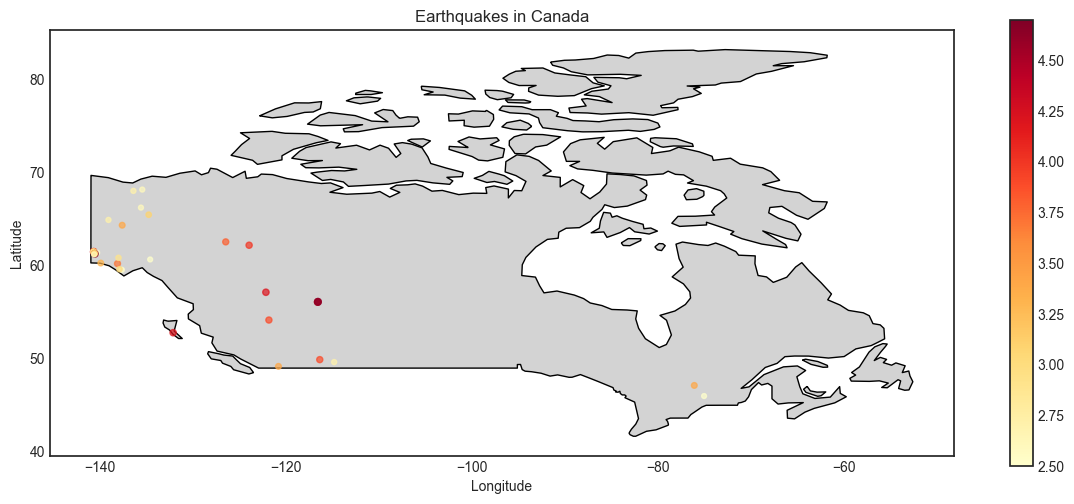

In [28]:
canada = world[world['name'] == 'Canada']

# Create a plot with a specific size and projection for Canada
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_aspect('auto')
canada.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the earthquakes within Canada
gdf_canada = gdf[gdf.within(canada.geometry.iloc[0])]
gdf_canada.plot(ax=ax, markersize=gdf_canada['mag'] * 5, column='mag', cmap='YlOrRd', alpha=0.7, legend=True)

# Set plot title and labels
ax.set_title('Earthquakes in Canada')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.tight_layout()
plt.show()

In [29]:
gdf.columns

Index(['Unnamed: 0', 'time', 'latitude', 'longitude', 'depth', 'mag',
       'magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place',
       'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource', 'year', 'location', 'geometry'],
      dtype='object')

In [30]:
gdf.head()

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,horizontalError,depthError,magError,magNst,status,locationSource,magSource,year,location,geometry
283308,283308,2023-01-31 23:50:22.840000+00:00,18.416600,-64.578300,5.000000,3.48,md,10.0,290.0,0.38360,...,3.960000,31.610000,0.080000,7.0,reviewed,pr,pr,2023,U.S. Virgin Islands,POINT (-64.57830 18.41660)
283309,283309,2023-01-31 23:14:56.290000+00:00,19.497000,-64.646833,37.750000,3.41,md,10.0,306.0,1.32800,...,3.060000,29.960000,0.041567,5.0,reviewed,pr,pr,2023,U.S. Virgin Islands,POINT (-64.64683 19.49700)
283310,283310,2023-01-31 22:09:53.919000+00:00,31.686449,-104.288675,7.416968,2.50,ml,22.0,64.0,0.02514,...,0.730716,0.716466,0.200000,18.0,reviewed,tx,tx,2023,New Mexico,POINT (-104.28868 31.68645)
283311,283311,2023-01-31 21:51:19.853000+00:00,-18.895000,-69.904800,111.094000,4.20,mb,24.0,115.0,0.48900,...,5.130000,5.891000,0.147000,13.0,reviewed,us,us,2023,Chile,POINT (-69.90480 -18.89500)
283312,283312,2023-01-31 21:41:15.080000+00:00,37.475167,-118.840167,3.940000,2.64,md,22.0,145.0,0.11500,...,0.320000,1.060000,0.148000,33.0,reviewed,nc,nc,2023,CA,POINT (-118.84017 37.47517)


In [31]:
from pysal.lib import weights
from pysal.explore import esda

gdf = gdf.set_crs("EPSG:4326", allow_override=True)
k = 15

w = weights.KNN.from_dataframe(gdf, k=k)

# # Check for disconnected components
# n_disconnected = w.n_components
# print('Number of disconnected components:', n_disconnected)

# # If there are still disconnected components, increase k and try again
# while n_disconnected > 0:
#     k += 1
#     w = weights.KNN.from_dataframe(gdf, k=k)
#     n_disconnected = w.n_components
#     print('Number of disconnected components with k =', k, ':', n_disconnected)

w.transform = 'r'

# Create a Moran's I statistic for the earthquakes
moran = esda.Moran(gdf['mag'], w)
print('Moran\'s I:', moran.I)
print('p-value:', moran.p_sim)

/Users/parthshah/Desktop/repo/earthquake_analysis/.venv/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/parthshah/Desktop/repo/earthquake_analysis/.venv/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(tria

Moran's I: 0.7833756435758131
p-value: 0.001


In [32]:
"""
The Moran's I statistic obtained is 0.7951917929037305, which is quite close to 1. 
This indicates a strong positive spatial autocorrelation, suggesting that similar values magnitude
are clustered together in geographical space. In other words, areas with high values of magnitude
are near other areas with high values, and areas with low values are near other areas with low values.

The p-value is 0.001, which is less than the commonly used significance level of 0.05.
This indicates strong evidence against the null hypothesis of random spatial distribution.
Thus, the spatial distribution of the magnitude is significantly different from random
and that there is significant clustering of similar values in the dataset.
"""

"\nThe Moran's I statistic obtained is 0.7951917929037305, which is quite close to 1. \nThis indicates a strong positive spatial autocorrelation, suggesting that similar values magnitude\nare clustered together in geographical space. In other words, areas with high values of magnitude\nare near other areas with high values, and areas with low values are near other areas with low values.\n\nThe p-value is 0.001, which is less than the commonly used significance level of 0.05.\nThis indicates strong evidence against the null hypothesis of random spatial distribution.\nThus, the spatial distribution of the magnitude is significantly different from random\nand that there is significant clustering of similar values in the dataset.\n"

Text(2, 2, 'HL')

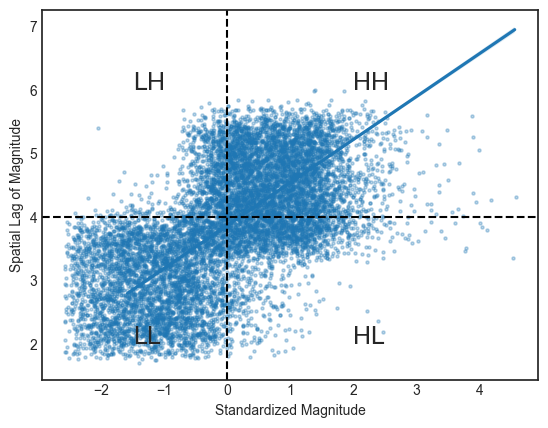

In [33]:
gdf['w_mag'] = weights.spatial_lag.lag_spatial(w, gdf['mag'])
# Standardize the magnitude values
gdf['mag_std'] = (gdf['mag'] - gdf['mag'].mean()) / gdf['mag'].std()
sns.regplot(x='mag_std', y='w_mag', data=gdf, x_jitter=True, y_jitter=True ,scatter_kws={'alpha':0.3, 's':5})

plt.xlabel('Standardized Magnitude')
plt.ylabel('Spatial Lag of Magnitude')

# Divide the above plot into 4 quadrants
plt.axvline(0, color='black', linestyle='--')
plt.axhline(4, color='black', linestyle='--')

# Put text in each quadrant
plt.text(-1.5, 6, 'LH', fontsize=18)
plt.text(2, 6, 'HH', fontsize=18)
plt.text(-1.5, 2, 'LL', fontsize=18)
plt.text(2, 2, 'HL', fontsize=18)

# The quadrants represent the following:
# LH: Low values surrounded by high values
# HH: High values surrounded by high values
# LL: Low values surrounded by low values
# HL: High values surrounded by low values

# HH and LL are examples of positive spatial autocorrelation as you can see
# most of the values are clustered together in HH and LL quadrants.

In [34]:
lisa = esda.Moran_Local(gdf['mag_std'], w)
print(pd.value_counts(lisa.q))

1    6459
3    4455
4     280
2      68
Name: count, dtype: int64


In [35]:
import numpy as np

print(lisa.Is.mean())
print(np.median(lisa.p_sim))

0.7833060843817466
0.001


Text(0.5, 1.0, 'Local Spatial Autocorrelation of Earthquake Magnitude')

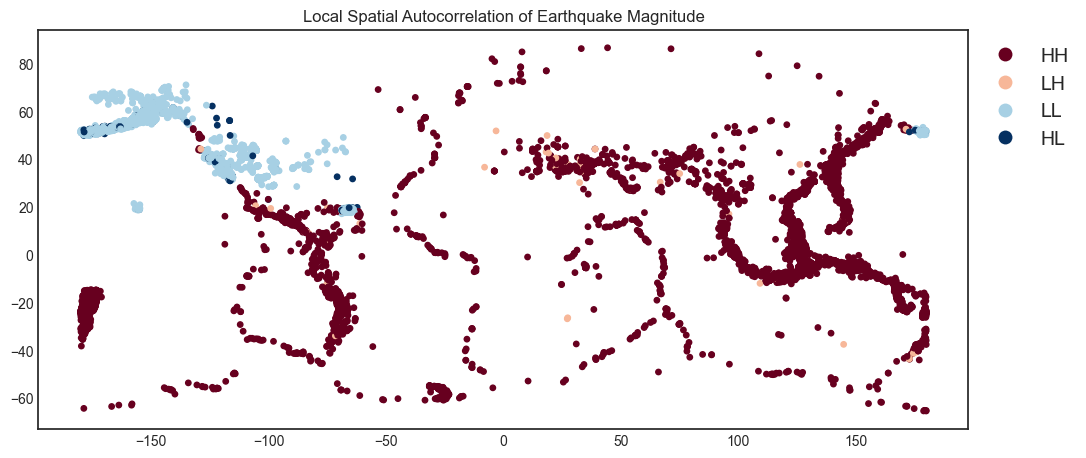

In [37]:
gdf['cl'] = lisa.q
quadrant_labels = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
gdf['cl_names'] = gdf['cl'].map(quadrant_labels)

# convert the new column to a categorical type
gdf['cl_names'] = pd.Categorical(gdf['cl_names'], categories=['HH', 'LH', 'LL', 'HL'], ordered=True)

# plot the map using the new column
gdf.plot(column='cl_names', categorical=True, figsize=(12, 8), cmap='RdBu', legend=True, markersize=15, legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'ncol': 1, 'fontsize': 14})


plt.title('Local Spatial Autocorrelation of Earthquake Magnitude')


In [ ]:
# The above plot shows the local spatial autocorrelation of the earthquake magnitude.
# The red areas represent high values surrounded by high values (HH), and the blue areas represent low values surrounded by low values (LL).

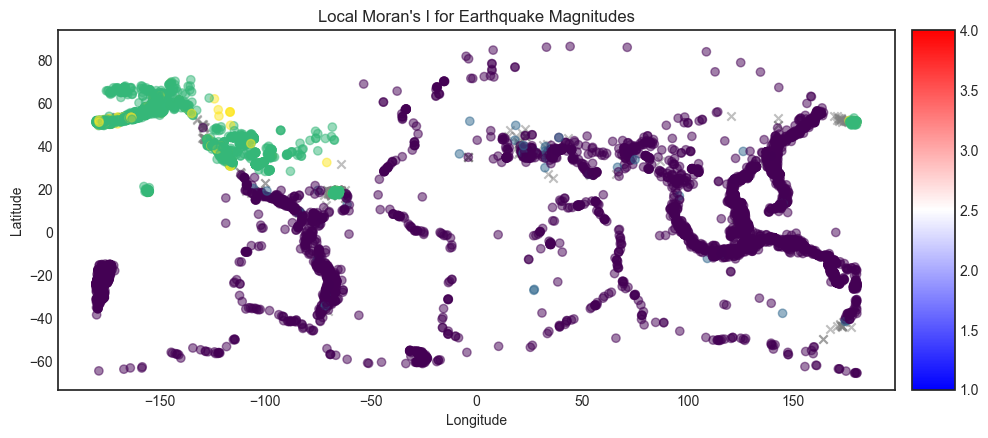

In [38]:
import contextily as ctx
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set a significance level
significance_level = 0.05

# Create a new column in your GeoDataFrame for significant local Moran's I values
gdf['significant_lisa'] = np.where(lisa.p_sim < significance_level, lisa.q, np.nan)

# Create a plot figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the locations with no significant local autocorrelation in a neutral color
gdf[gdf['significant_lisa'].isna()].plot(ax=ax, color='grey', marker='x',alpha=0.5)

# Plot the locations with significant local autocorrelation, colored by the type of autocorrelation
plot = gdf[gdf['significant_lisa'].notna()].plot(ax=ax, column='significant_lisa', legend=False, cmap=cmap, alpha=0.5)

# create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Create a color map
cmap = mcolors.LinearSegmentedColormap.from_list("", ["blue","white","red"])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=1, vmax=4))
sm.set_array([])

# Create a colorbar
fig.colorbar(sm, cax=cax, orientation="vertical")

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Local Moran\'s I for Earthquake Magnitudes')

plt.tight_layout()
plt.show()